In [2]:
### Basic imports
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2

### Imports required to test different optimization settings
from qiskit.transpiler import PassManager
from qiskit.transpiler.preset_passmanagers import level_1_pass_manager, level_2_pass_manager
from qiskit.transpiler import PassManagerConfig
from qiskit.transpiler import CouplingMap

import numpy as np
import json

### Basic setup
---

In [ ]:
### Helper functions

def save_to_json(data, filename):
    with open(filename, 'w') as json_file:
        json.dump(data, json_file, indent=4)

def load_from_json(filename):
    with open(filename, 'r') as json_file:
        data = json.load(json_file)
    return [tuple(i) for i in data]

def get_pauli(pauli):
    """
    Convert a string representation of a Pauli product into its matrix form.

    Parameters:
    -----------
    pauli : str
        String representing the Pauli product, e.g., 'XYZX'. Each character
        in the string should be one of 'X', 'Y', 'Z', or 'I'.

    Returns:
    --------
    np.ndarray
        The matrix representation of the Pauli product.
    """
    init = pauli[0]
    pauli = pauli[1:]
    if init == 'X':
        out = np.array([[0, 1], [1, 0]])
    elif init == 'Z':
        out = np.array([[1, 0], [0, -1]])
    elif init == 'Y':
        out = np.array([[0, -1j], [1j, 0]])
    else:
        out = np.eye(2)
    for p in pauli:
        if p == 'X':
            out = np.kron(out, np.array([[0, 1], [1, 0]]))
        elif p == 'Z':
            out = np.kron(out, np.array([[1, 0], [0, -1]]))
        elif p == 'Y':
            out = np.kron(out, np.array([[0, -1j], [1j, 0]]))
        else:
            out = np.kron(out, np.eye(2))
    return out

def count_gates(qc,size):
    """
    Count the occurrences of size-qubit gates in a quantum circuit.

    Parameters:
    -----------
    qc : QuantumCircuit
        The quantum circuit to analyze.
    size : int
        type of gate to count, given by number of affected qubits.

    Returns:
    --------
    int
        The number of size-qubit gates in the quantum circuit.
    """
    count = 0
    for gate in qc.data:
        qubits_involved = gate[1]
        if len(qubits_involved) == size:
            count += 1
    print(f"Number of {str(size)}-qubit gates: {count}")

def scale_Pauli(Pauli , coeff):
    """Return Copy of Pauli, given as a dictionary, with all coefficients scaled by coeff."""
    return {key: value * coeff for key, value in Pauli.items()}

def subset_Pauli(Pauli , n):
    """Returns only the first n entries of Pauli."""
    return dict(list(Pauli.items())[:n])

def print_hamiltonian(Pauli_Dict):
    """Print Hamiltonian given as dictionary of Pauli Products."""
    string = "Hamiltonian: "
    for key in Pauli_Dict.keys():
        string += str(Pauli_Dict.get(key)) + "*" + key + " + "
    print(string[:-2])


In [ ]:
#Build quantum circuit to simulate a given Hamiltonian.
#copied from https://medium.com/quantum-untangled/hamiltonian-simulation-with-quantum-computation-fedc7cdc02e0

def sim_z(t, qc, qubits):
    """
    Add gates to simulate a Pauli Z string exponential.
   
    Parameters:
        t: float
            Time parameter to simulate for
        qc: QuantumCircuit
            Circuit to append gates to
        qubits: array
            Array indicating qubits indeces (in order) to 
            append the gates to
    """
    for i in range(len(qubits) - 1):
        qc.cx(qubits[i], qubits[i + 1])
    qc.rz(-2 * t, qubits[-1])
    for i in range(len(qubits) - 1, 0, -1):
        qc.cx(qubits[i - 1], qubits[i])

def sim_pauli(arr, t, qc, qubits):
    """
    Append gates to simulate any Pauli string
    
    Parameters:
        arr: array
            Array encoding the Pauli string
        t: float
            Time parameter to simulate for
        qc: QuantumCircuit
            Circuit to append gates to
        qubits: array
            Array indicating qubits indeces (in order) to 
            append the gates to
    """
    new_arr = []
    new_qub = []
    for idx in range(len(arr)):
        if arr[idx] != 'I':
            new_arr.append(arr[idx])
            new_qub.append(qubits[idx])

    h_y = 1 / np.sqrt(2) * np.array([[1, -1j], [1j, -1]])
    for i in range(len(new_arr)):
        if new_arr[i] == 'X':
            qc.h(new_qub[i])
        elif new_arr[i] == 'Y':
            qc.unitary(h_y, [new_qub[i]], r'$H_y$')
            
    sim_z(t, qc, new_qub)
    
    for i in range(len(new_arr)):
        if new_arr[i] == 'X':
            qc.h(new_qub[i])
        elif new_arr[i] == 'Y':
            qc.unitary(h_y, [new_qub[i]], r'$H_y$')

def sim_ham(hamiltonian, t, qc, qubits, trotter=1):
    """
    Simulates Hamiltonian given as Pauli string, using trotterization.
    
    Parameters:
        hamiltonian: dict
            Dictionary encoding the hamiltonian with each
            Pauli product as a key with the coefficient as value
        t: float
            Time parameter to simulate for
        qc: QuantumCircuit
            Circuit to append gates to
        qubits: array
            Array indicating qubits indeces (in order) to 
            append the gates to
        trotter: trotterization factor
        
    """
    temp    = QuantumCircuit(len(qubits))
    delta_t = t / trotter
    for pauli in hamiltonian:
        sim_pauli(pauli, hamiltonian[pauli] * delta_t, temp, range(len(qubits)))
        
    for i in range(trotter):
        qc.compose(temp, qubits, inplace=True)

In [ ]:
### Build the circuit

def create_circuit(qbits,trotter,Paulis):
    """Create the quantum Circuit for given Paulis and Trotter number."""
    qc = QuantumCircuit(qbits)
    sim_ham(Paulis, 1 / (2 * np.pi), qc, range(qbits), trotter=trotter)
    qc = qc.reverse_bits()
    return qc

def sim_ham_Suzuki2(hamiltonian, t, qc, qubits, trotter=1):
    """Variant of sim_ham, that simulates Hamiltonian by Suzuki decomposition of order 2."""
    temp    = QuantumCircuit(len(qubits))
    delta_t = t / (trotter *2)
    for pauli in hamiltonian:
        sim_pauli(pauli, hamiltonian[pauli] * delta_t, temp, range(len(qubits)))
    for pauli in reversed(hamiltonian):
        sim_pauli(pauli, hamiltonian[pauli] * delta_t, temp, range(len(qubits)))
        
    for i in range(trotter):
        qc.compose(temp, qubits, inplace=True)
        
def create_circuit_Suzuki2(qbits,trotter,Paulis):
    """Variant of create_circuit, that creates the circuit for a Suzuki decomp of order 2 instead."""
    qc = QuantumCircuit(qbits)
    sim_ham_Suzuki2(Paulis, 1 / (2 * np.pi), qc, range(qbits), trotter=trotter)
    qc = qc.reverse_bits()
    return qc

### Prepare experiments
---

Hamiltonian: 5.0*XXX + 5.0*XXY + 5.0*XXZ + 5.0*XYI + 5.0*XZI + 5.0*YII + 5.0*ZII 


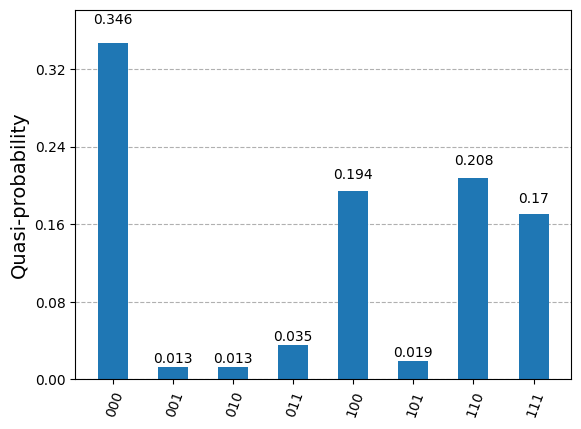

In [ ]:
### Define Hamiltonian and Trotter number. Display corresponding distribution given by simulator

TROTTER_NUMBER = 4

'''Example Hamiltonians, given as sum of anticommuting Paulis (see section 4.2 of https://arxiv.org/pdf/1909.08123). Throughout this script, Hamiltonians are given as a weighted sum of Pauli operators, represented by a dictionary of operators and their coefficients.'''
Hamiltonian_2qb_standard = {"XX": 1.0 ,"XY": 1.0 ,"XZ": 1.0 ,"YI": 1.0 ,"ZI": 1.0 }
Hamiltonian_3qb_standard = {"XXX" : 1.0 ,"XXY" : 1.0 ,"XXZ" : 1.0 ,"XYI" : 1.0 ,"XZI" : 1.0 ,"YII" : 1.0 ,"ZII" : 1.0 } 
Hamiltonian_4qb_standard = {"XXXX": 1.0 ,"XXXY": 1.0 ,"XXXZ": 1.0 ,"XXYI": 1.0 ,"XXZI": 1.0 ,"XYII": 1.0 ,"XZII": 1.0 ,"YIII": 1.0 ,"ZIII": 1.0}
Matrix_5qb_standard = {"XXXXX": 1.0 ,"XXXXY": 1.0 ,"XXXXZ": 1.0 ,"XXXYI": 1.0 ,"XXXZI": 1.0 ,"XXYII": 1.0 ,"XXZII": 1.0 ,"XYIII": 1.0 ,"XZIII": 1.0 ,"YIIII": 1.0 ,"ZIIII": 1.0 }

Pauli = scale_Pauli(subset_Pauli(Hamiltonian_3qb_standard,11),5.0)
print_hamiltonian(Pauli)

qbits = len(list(Pauli.keys())[0]) 
qc = create_circuit(qbits, TROTTER_NUMBER, Pauli)

plot_histogram(Statevector.from_instruction(qc).probabilities_dict())


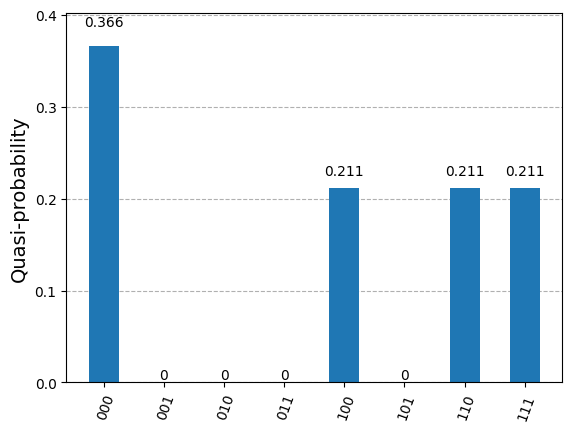

In [7]:
### Compute and display ideal distribution for given Hamiltonian. 

qc_optimal = create_circuit(qbits,1000,Pauli)
ideal_distribution = Statevector.from_instruction(qc_optimal).probabilities_dict()
plot_histogram(ideal_distribution)

/var/folders/y3/9zm3nwts2156p01j_5s0xtdw0000gn/T/ipykernel_65904/2780502535.py:66: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  qubits_involved = gate[1]


Number of 2-qubit gates: 64


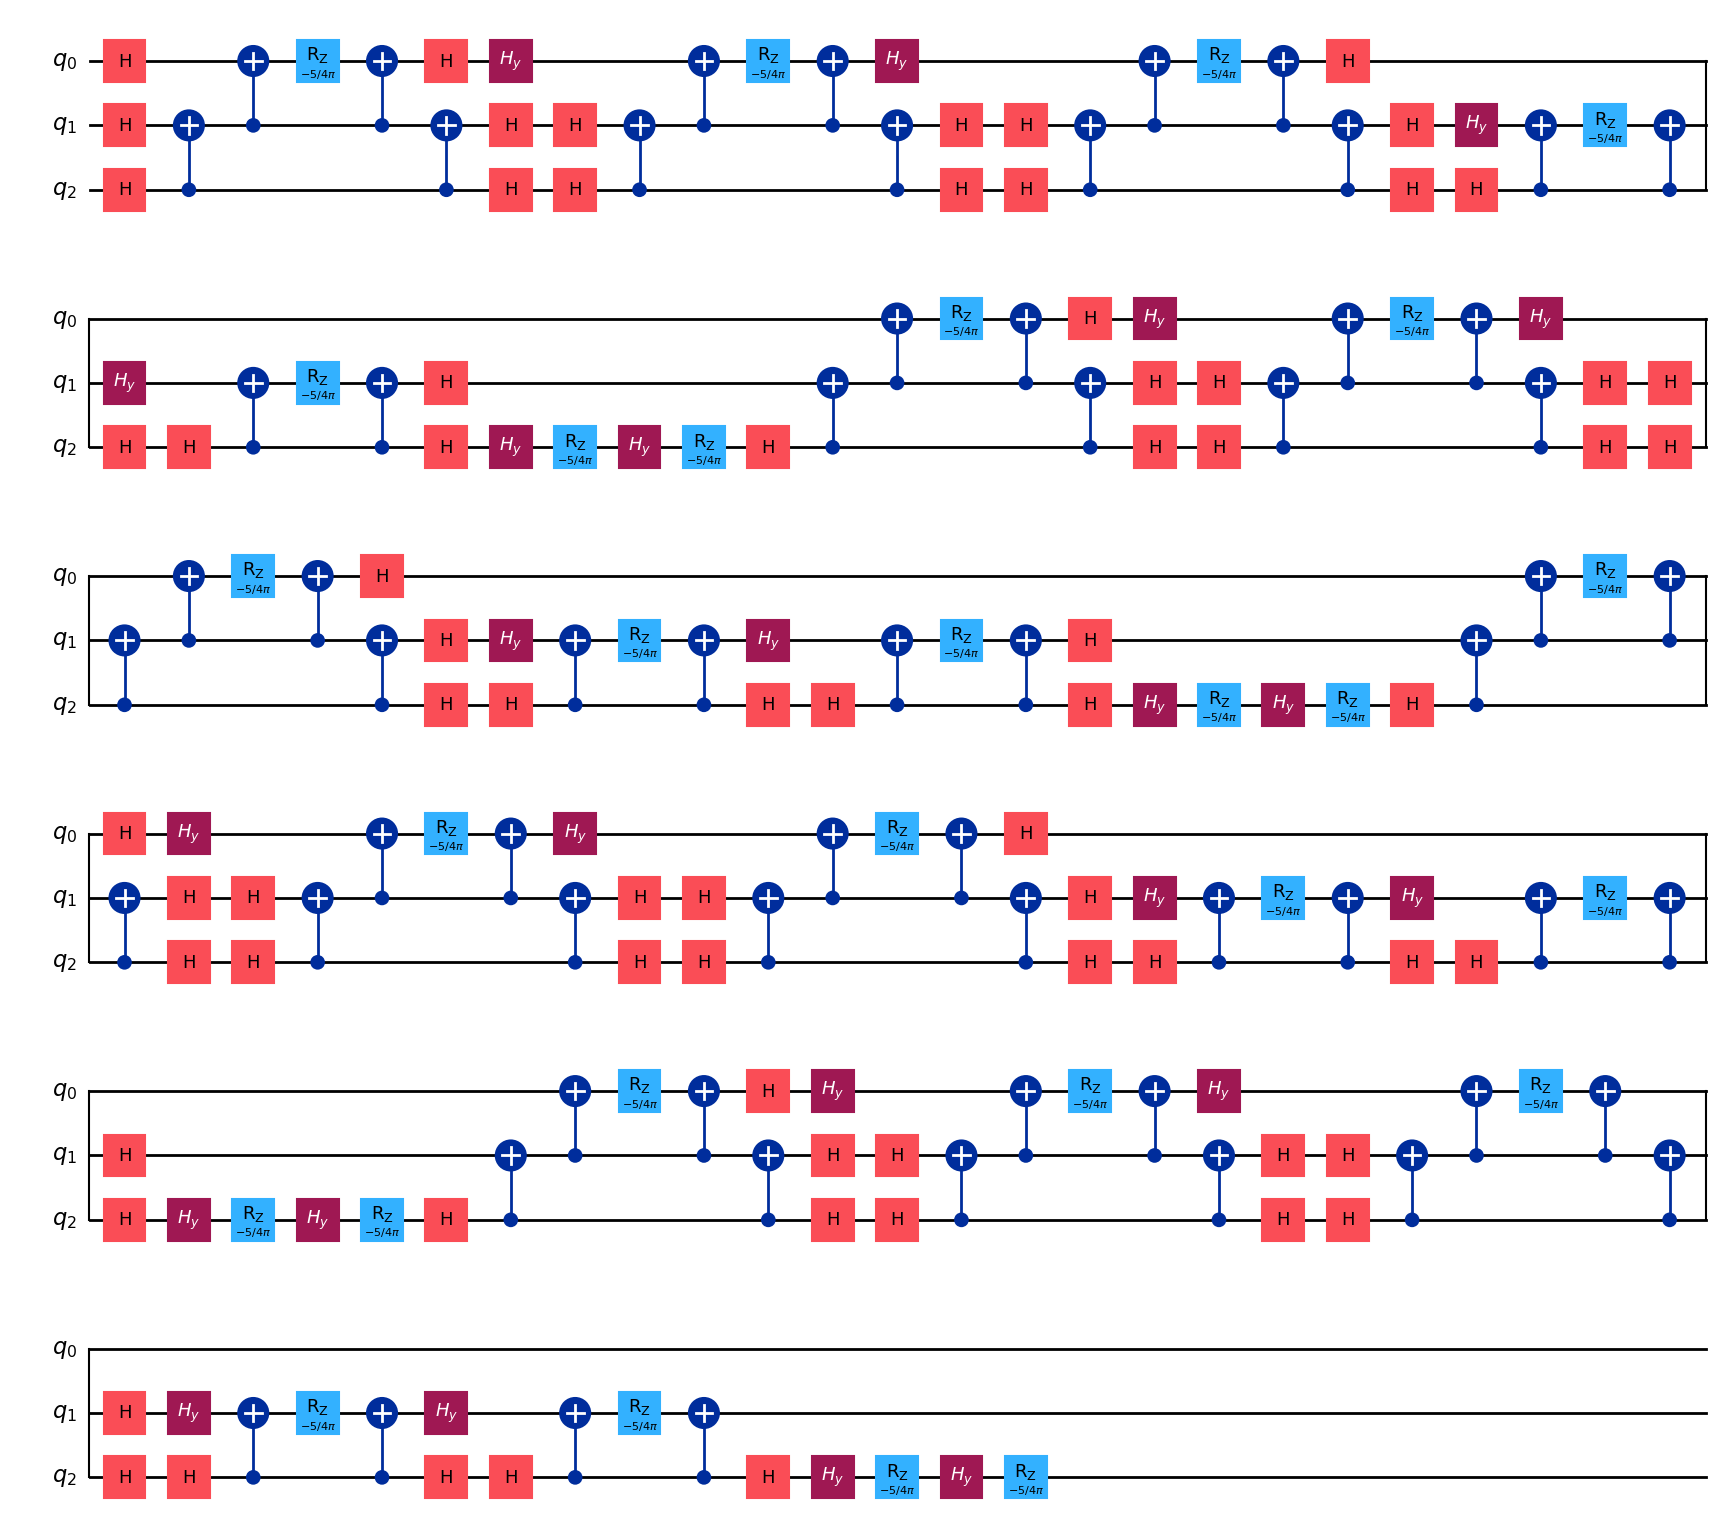

In [8]:
#Examine the current quantum circuit

count_gates(qc,2)
qc.draw('mpl')

In [9]:
# Setup and connect to backend. Access token required.

with open("../token.txt", 'r') as file:
    token = file.readline().rstrip('\n')
service = QiskitRuntimeService(channel="ibm_quantum", token=token) 
backend = service.least_busy(operational=True, simulator=False)

'''#Offline backend for testing:
service = QiskitRuntimeService()
backend = service.backend('ibm_rensselaer')'''

backend.name

'ibm_torino'

In [ ]:
### Create a custom pass manager, to test effects of different optimization settings.

#Available passes for default level 2 pass manager: ['ContainsInstruction', 'ConditionalController', 'UnitarySynthesis', 'HighLevelSynthesis', 'BasisTranslator', 'ElidePermutations', 'RemoveDiagonalGatesBeforeMeasure', 'InverseCancellation', 'SetLayout', 'ConditionalController', 'ConditionalController', 'ConditionalController', 'CheckMap', 'ConditionalController', 'ConditionalController', 'ConditionalController', 'FilterOpNodes', 'UnitarySynthesis', 'HighLevelSynthesis', 'BasisTranslator', 'CheckGateDirection', 'ConditionalController', 'Collect2qBlocks', 'ConsolidateBlocks', 'UnitarySynthesis', 'Depth', 'FixedPoint', 'Size', 'FixedPoint', 'DoWhileController']

#List of passes to be exluded, e.g Filterlist = [ 'CommutativeCancellation','ElidePermutations', 'RemoveDiagonalGatesBeforeMeasure',  'Collect2qBlocks', 'ConsolidateBlocks']
Filterlist = [ ]

def filter_pass_manager(staged_pass_manager,filter_list):
    """filter out passes given in filter_list from pass manager staged_pass_manager."""
    new_pass_manager = PassManager()
    for task in staged_pass_manager._tasks:  
        for pass_ in task:  
            # Exclude CommutativeCancellation pass
            #print(pass_.__class__.__name__)
            if pass_.__class__.__name__ not in filter_list:
                new_pass_manager.append(pass_)
                filter_list.append(pass_.__class__.__name__)
    return new_pass_manager

coupling_map = CouplingMap(backend.configuration().coupling_map)
basis_gates = backend.configuration().basis_gates
backend_properties = backend.properties()
pass_manager_config = PassManagerConfig(
    basis_gates=basis_gates,
    coupling_map=coupling_map,
    backend_properties=backend_properties
)
default_pass_manager = level_2_pass_manager(pass_manager_config)
custom_pass_manager = filter_pass_manager(default_pass_manager,Filterlist)


/var/folders/y3/9zm3nwts2156p01j_5s0xtdw0000gn/T/ipykernel_65904/635421296.py:21: DeprecationWarning: ``qiskit.transpiler.passmanager_config.PassManagerConfig.__init__()``'s argument ``backend_properties`` is deprecated as of Qiskit 1.4. It will be removed in Qiskit 2.0. The BackendProperties data structure has been deprecated and will be removed in Qiskit 2.0. The `target` input argument should be used instead. You can use Target.from_configuration() to build the target from the properties object, but in 2.0 you will need to generate a target directly.
  pass_manager_config = PassManagerConfig(


### Perform experiments
---

In [ ]:
def create_params(qbits,trotter,optimisation):
    return {"qbits" : qbits , "trotter" : trotter , "optimisation" : optimisation}

#Define all experiments to do, by number of Trotter values and optimization settings to try 
experiments = []
for i in range(20):
    experiments.append(create_params(qbits,i+1,3))

#Create the circuits, corresponding the Pauli defined above and the different experiments
circuits_list = []
for exp in experiments:
    circ = create_circuit(exp["qbits"] , exp["trotter"], Pauli)
    circ_transpiled = transpile(circ.measure_all(inplace = False), backend, optimization_level=exp["optimisation"], seed_transpiler=0) 
    """for custom pass manager use instead:
    circ_transpiled = custom_pass_manager.run(circ.measure_all(inplace = False))"
    """ 
    circuits_list.append(circ_transpiled)


/var/folders/y3/9zm3nwts2156p01j_5s0xtdw0000gn/T/ipykernel_65904/2780502535.py:66: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  qubits_involved = gate[1]


Number of 2-qubit gates: 17
Number of 1-qubit gates: 122
Number of swap gates: 0


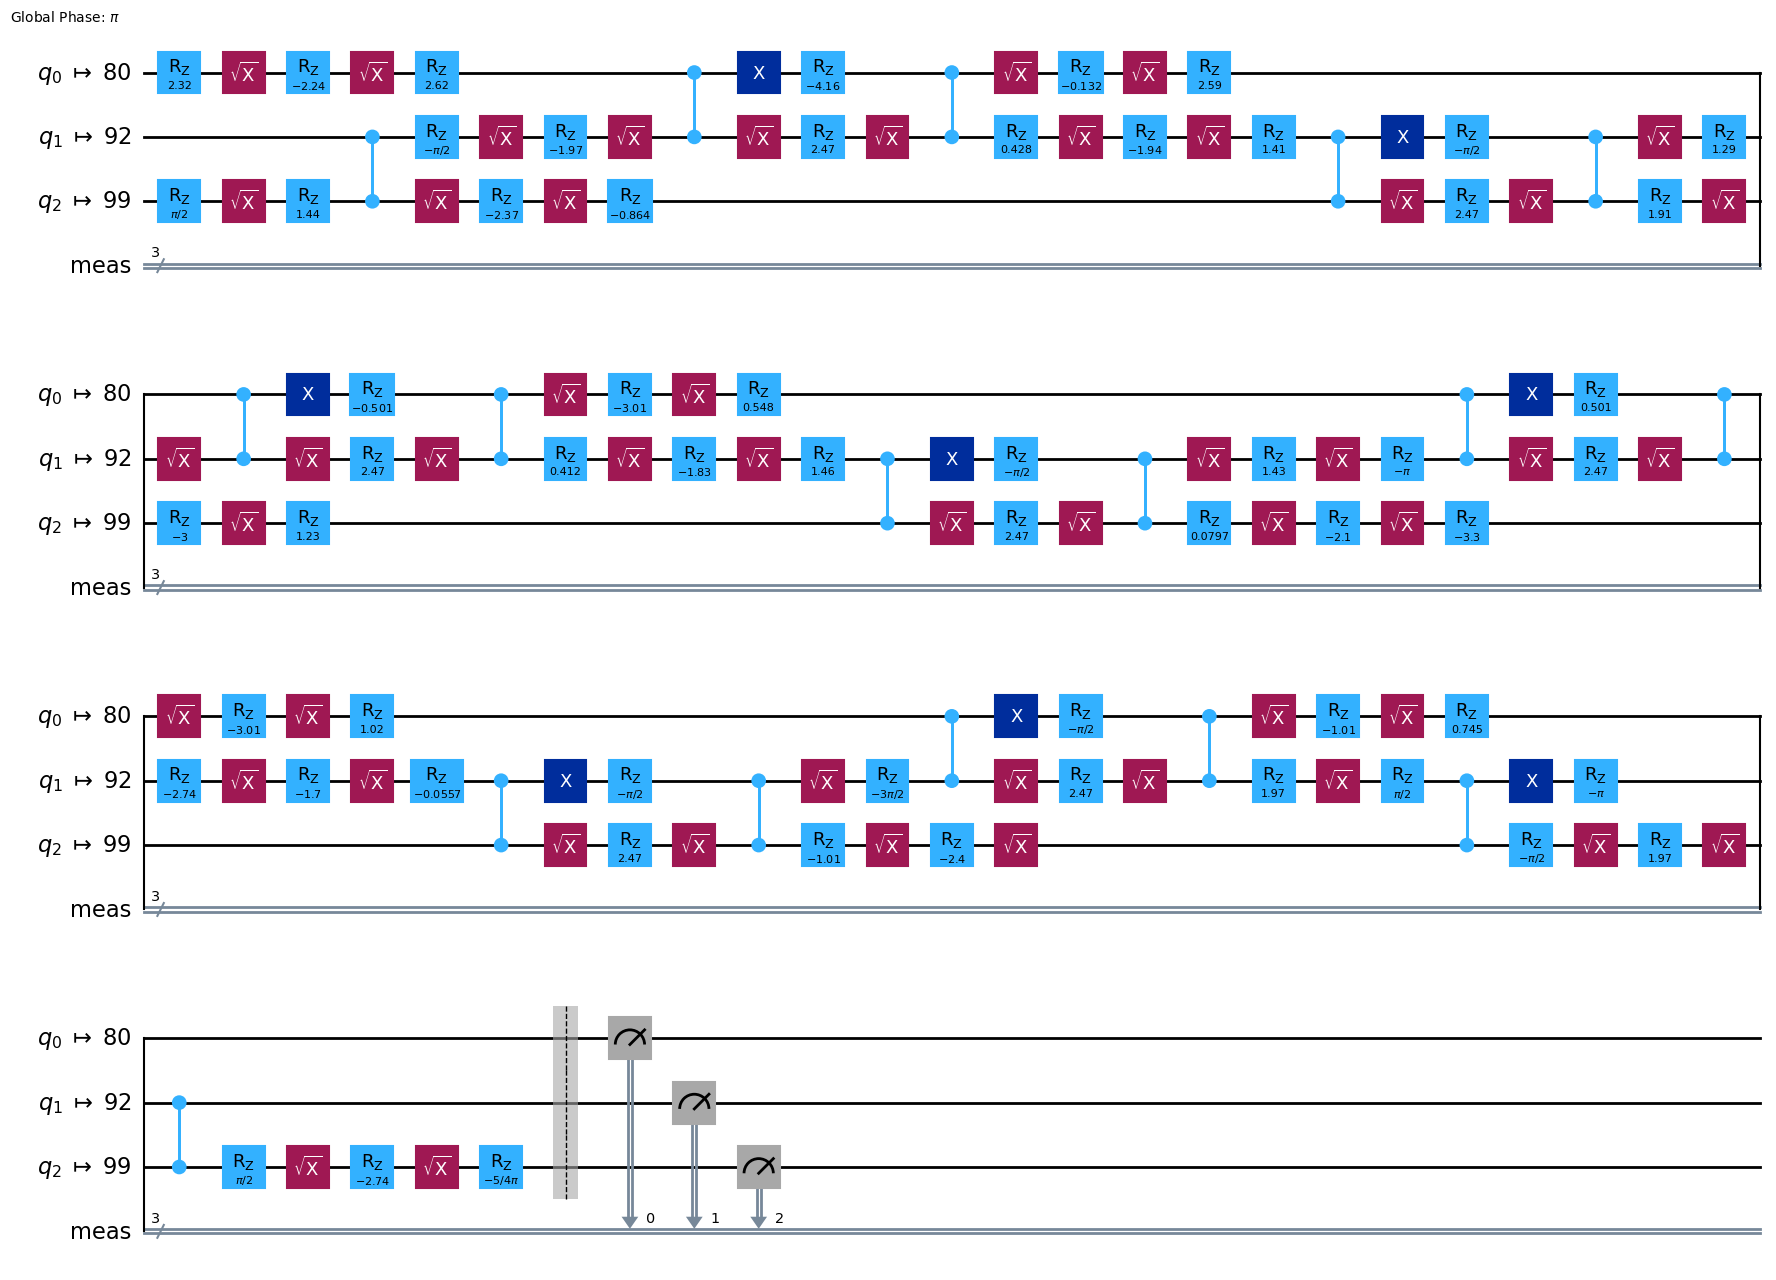

In [ ]:
### Draw qc after transpilation to backend and count gates again

circ_transpiled_1 = transpile(qc.measure_all(inplace=False), backend, optimization_level=3, seed_transpiler=0) 
count_gates(circ_transpiled_1, 2)
count_gates(circ_transpiled_1, 1)
print(f"Number of swap gates: {circ_transpiled_1.count_ops().get('swap', 0)}")
circ_transpiled_1.draw(output='mpl', idle_wires=False)

In [ ]:
#Run the experiment. Final results is list of (params : dict , measurements : dict) tuples

SHOTS = 1000 #number of measurements. Increase for more accurate results.

#Run the experiment
sampler = SamplerV2(mode = backend)
job = sampler.run(pubs = circuits_list, shots = SHOTS)
result = job.result()
final_result = list(zip(experiments, [i.data.meas.get_counts() for i in result]))

#Add optimal Solution to result
optimal_solution_entry = ({"Simulator" : 1, "Shots" : SHOTS, "Pauli" : Pauli}, {str(key) : round(value * SHOTS) for key, value in ideal_distribution.items()})
final_result.append(optimal_solution_entry)


In [16]:
final_result

[({'qbits': 3, 'trotter': 1, 'optimisation': 3},
  {'101': 114,
   '111': 117,
   '000': 141,
   '010': 160,
   '100': 93,
   '001': 133,
   '110': 86,
   '011': 156}),
 ({'qbits': 3, 'trotter': 2, 'optimisation': 3},
  {'000': 208,
   '110': 180,
   '100': 183,
   '101': 75,
   '111': 105,
   '010': 74,
   '011': 99,
   '001': 76}),
 ({'qbits': 3, 'trotter': 3, 'optimisation': 3},
  {'000': 280,
   '100': 175,
   '110': 177,
   '111': 178,
   '101': 50,
   '011': 65,
   '010': 21,
   '001': 54}),
 ({'qbits': 3, 'trotter': 4, 'optimisation': 3},
  {'010': 30,
   '100': 189,
   '101': 37,
   '111': 178,
   '110': 196,
   '000': 288,
   '011': 44,
   '001': 38}),
 ({'qbits': 3, 'trotter': 5, 'optimisation': 3},
  {'010': 42,
   '111': 183,
   '110': 193,
   '000': 246,
   '100': 225,
   '011': 46,
   '001': 27,
   '101': 38}),
 ({'qbits': 3, 'trotter': 6, 'optimisation': 3},
  {'110': 271,
   '111': 121,
   '000': 242,
   '100': 216,
   '010': 39,
   '101': 40,
   '011': 32,
   '001': 39

In [18]:
save_to_json(final_result , "Experiment_data/First_experiment.json")